In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
etf_price  = pd.read_csv('data_directory/etf_price.csv', header=[0,1], index_col=0)
stock_price = pd.read_csv('data_directory/stock_price.csv', header=[0,1], index_col=0)

etf_price.index = list(map(str, etf_price.index))
stock_price.index = list(map(str, stock_price.index))

# OCI 기업으로 테스트

In [3]:
first_col = []
second_col = []

for col in stock_price.columns:
    first_col.append(col[1])
    second_col.append(col[0])

stock_price.columns = [first_col,second_col]
oci = stock_price['A010060'].copy()

# bollinger band 그리기

In [4]:
oci['MA20'] = oci['close'].rolling(window=20).mean()
oci['stddev'] = oci['close'].rolling(window=20).std()
oci['upper'] = oci['MA20'] + oci['stddev'] * 2
oci['lower'] = oci['MA20'] - oci['stddev'] * 2


In [5]:
oci_cut = oci.loc['2020':]

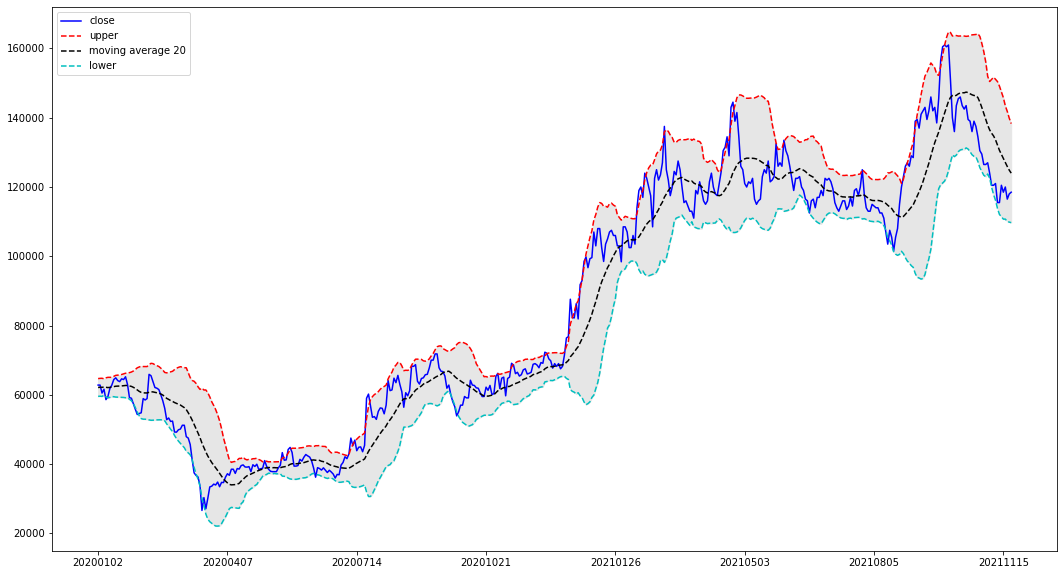

In [6]:
plt.figure(figsize=(18,10))
plt.plot(oci_cut.index, oci_cut['close'], color='#0000ff', label='close')
plt.plot(oci_cut.index, oci_cut['upper'], 'r--', label='upper')
plt.plot(oci_cut.index, oci_cut['MA20'], 'k--', label='moving average 20')
plt.plot(oci_cut.index, oci_cut['lower'], 'c--', label='lower')
plt.fill_between(oci_cut.index, oci_cut['upper'], oci_cut['lower'], color='0.9')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()
plt.show()


In [7]:
oci['PB'] = (oci['close'] - oci['lower']) / (oci['upper'] - oci['lower'])
oci_cut = oci.loc['2020':]

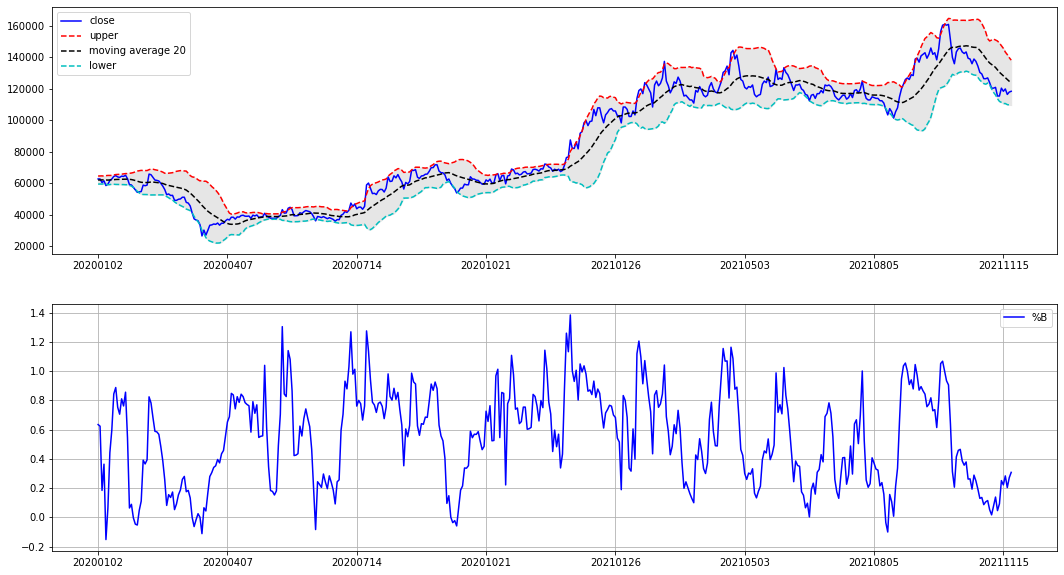

In [8]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci_cut.index, oci_cut['close'], color='#0000ff', label='close')
plt.plot(oci_cut.index, oci_cut['upper'], 'r--', label='upper')
plt.plot(oci_cut.index, oci_cut['MA20'], 'k--', label='moving average 20')
plt.plot(oci_cut.index, oci_cut['lower'], 'c--', label='lower')
plt.fill_between(oci_cut.index, oci_cut['upper'], oci_cut['lower'], color='0.9')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(oci_cut.index, oci_cut['PB'], color='b', label='%B')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()
plt.grid(True)
plt.show()


# 추세추종 기법

In [10]:
oci['TP'] = (oci['high'] + oci['low'] + oci['close']) / 3
oci['PMF'] = 0
oci['NMF'] = 0
for i in range(len(oci.close) - 1):
    if oci.TP.values[i] < oci.TP.values[i+1]:
        oci.PMF.values[i+1] = oci.TP.values[i+1] * oci.volume.values[i+1]
        oci.NMF.values[i+1] = 0
    else:
        oci.NMF.values[i+1] = oci.TP.values[i+1] * oci.volume.values[i+1]
        oci.PMF.values[i+1] = 0
oci['MFR'] = oci.PMF.rolling(window=10).sum() / oci.NMF.rolling(window=10).sum()
oci['MFI10'] = 100 - 100 / (1 + oci['MFR'])

In [11]:
oci['MFI10']

20120102          NaN
20120103          NaN
20120104          NaN
20120105          NaN
20120106          NaN
              ...    
20211115    29.492850
20211116    37.982025
20211117    29.477986
20211118    32.600879
20211119    40.109634
Name: MFI10, Length: 2434, dtype: float64

In [12]:
oci_cut = oci.loc['2020':]

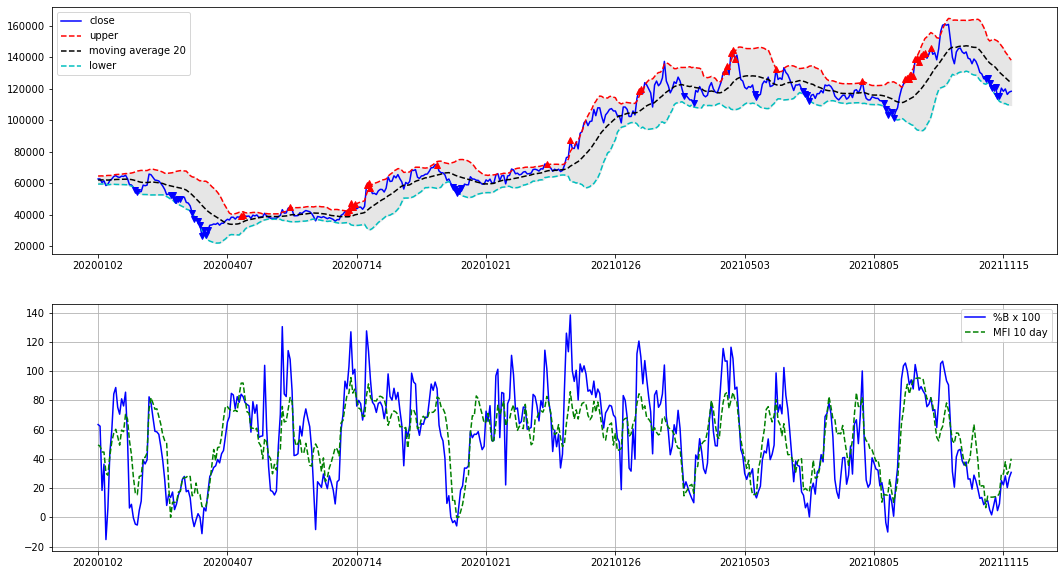

In [13]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci_cut.index, oci_cut['close'], color='#0000ff', label='close')
plt.plot(oci_cut.index, oci_cut['upper'], 'r--', label='upper')
plt.plot(oci_cut.index, oci_cut['MA20'], 'k--', label='moving average 20')
plt.plot(oci_cut.index, oci_cut['lower'], 'c--', label='lower')
plt.fill_between(oci_cut.index, oci_cut['upper'], oci_cut['lower'], color='0.9')
for i in range(len(oci_cut.close)):
    if oci_cut.PB.values[i] > 0.8 and oci_cut.MFI10.values[i] > 80:
        plt.plot(oci_cut.index.values[i], oci_cut.close.values[i], 'r^')
    elif oci_cut.PB.values[i] < 0.2 and oci_cut.MFI10.values[i] < 20:
        plt.plot(oci_cut.index.values[i], oci_cut.close.values[i], 'bv')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(oci_cut.index, oci_cut['PB'] * 100, color='b', label='%B x 100')
plt.plot(oci_cut.index, oci_cut['MFI10'], 'g--', label='MFI 10 day')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()
plt.grid(True)
plt.show()


In [14]:
balance = pd.DataFrame(columns = ['cash','stock','total'], index = oci.index)

buying = False

buy_date = []
sell_date = []

balance.loc[balance.index[0], 'cash'] = 500000
balance.loc[balance.index[0], 'stock'] = 0
balance.loc[balance.index[0], 'total'] = 500000


for i in range(1, len(oci.close)):
    if buying == False:
        if oci.PB.values[i-1] > 0.8 and oci.MFI10.values[i-1] > 80:
            buying = True
            number = balance.loc[balance.index[i-1], 'cash'] // oci.loc[oci.index[i], 'open']
            balance.loc[balance.index[i], 'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
        else:
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
    else:
        if oci.PB.values[i-1] < 0.2 and oci.MFI10.values[i-1] < 20:
            buying = False
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
        else:
            balance.loc[balance.index[i],'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

    balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']

In [15]:
balance.loc['202109':]

,cash,stock,total
20210901,60800,502000,562800
20210902,60800,508000,568800
20210903,60800,520000,580800
20210906,60800,512000,572800
20210907,60800,550000,610800
20210908,60800,566000,626800
20210909,60800,552000,612800
20210910,60800,570000,630800
20210913,60800,564000,624800
20210914,60800,572000,632800


In [16]:
balance['rate_of_return'] = balance['total'] / 500000

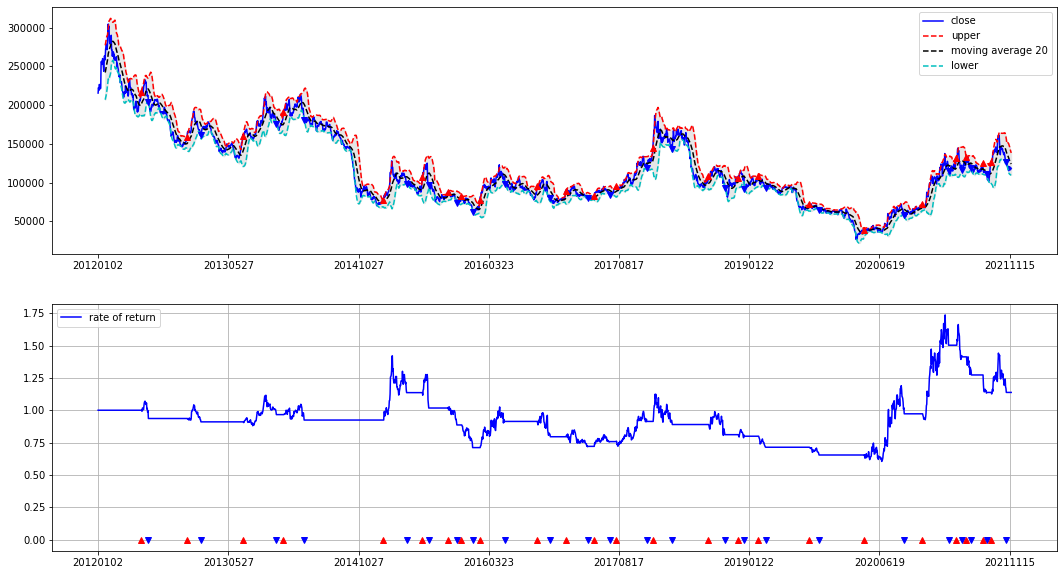

In [17]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['upper'], 'r--', label='upper')
plt.plot(oci.index, oci['MA20'], 'k--', label='moving average 20')
plt.plot(oci.index, oci['lower'], 'c--', label='lower')
plt.fill_between(oci.index, oci['upper'], oci['lower'], color='0.9')
buying = False
for i in range(len(oci.close)):
    if oci.PB.values[i] > 0.8 and oci.MFI10.values[i] > 80 and buying == False:
        buying = True
        plt.plot(oci.index.values[i], oci.close.values[i], 'r^')
    elif oci.PB.values[i] < 0.2 and oci.MFI10.values[i] < 20 and buying == True:
        buying = False
        plt.plot(oci.index.values[i], oci.close.values[i], 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(oci.index, balance['rate_of_return'], color='b', label='rate of return')
buying = False
for i in range(len(oci.close)):
    if oci.PB.values[i] > 0.8 and oci.MFI10.values[i] > 80 and buying == False:
        buying = True
        plt.plot(oci.index.values[i], 0, 'r^')
    elif oci.PB.values[i] < 0.2 and oci.MFI10.values[i] < 20 and buying == True:
        buying = False
        plt.plot(oci.index.values[i], 0, 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.grid(True)
plt.show()


# 반전매매 기법

In [18]:
oci['II'] = (2 * oci['close'] - oci['high'] - oci['low']) / (oci['high'] - oci['low']) * oci['volume']
oci['IIP21'] = oci['II'].rolling(window=21).sum() / oci['volume'].rolling(window=21).sum() * 100

In [19]:
oci_cut = oci.loc['2020':]

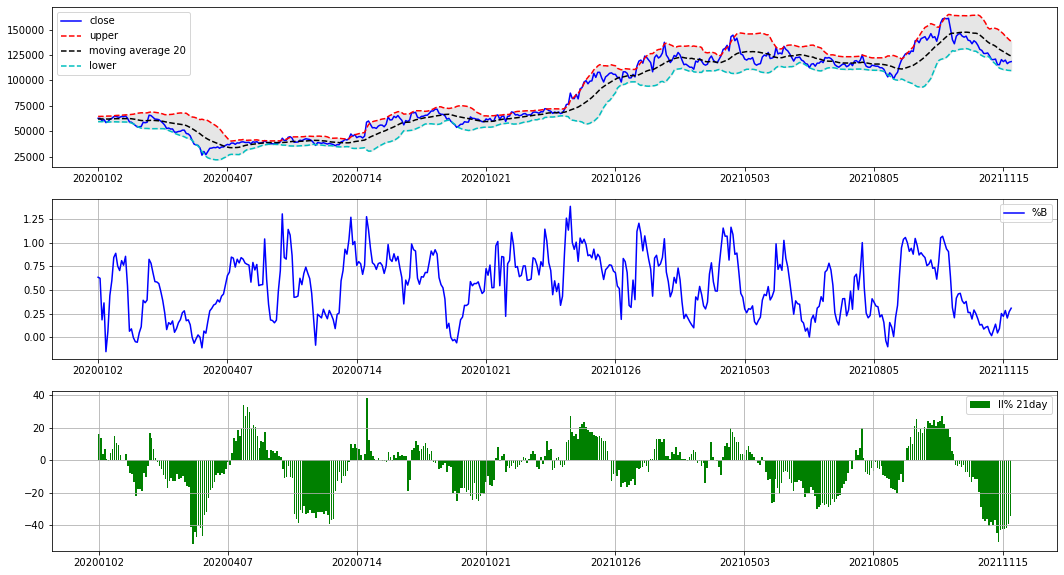

In [20]:
plt.figure(figsize=(18,10))
plt.subplot(3,1,1)
plt.plot(oci_cut.index, oci_cut['close'], color='#0000ff', label='close')
plt.plot(oci_cut.index, oci_cut['upper'], 'r--', label='upper')
plt.plot(oci_cut.index, oci_cut['MA20'], 'k--', label='moving average 20')
plt.plot(oci_cut.index, oci_cut['lower'], 'c--', label='lower')
plt.fill_between(oci_cut.index, oci_cut['upper'], oci_cut['lower'], color='0.9')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()

plt.subplot(3,1,2)
plt.plot(oci_cut.index, oci_cut['PB'], color='b', label='%B')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.bar(oci_cut.index, oci_cut['IIP21'], color='g', label='II% 21day')
plt.grid(True)
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()
plt.show()


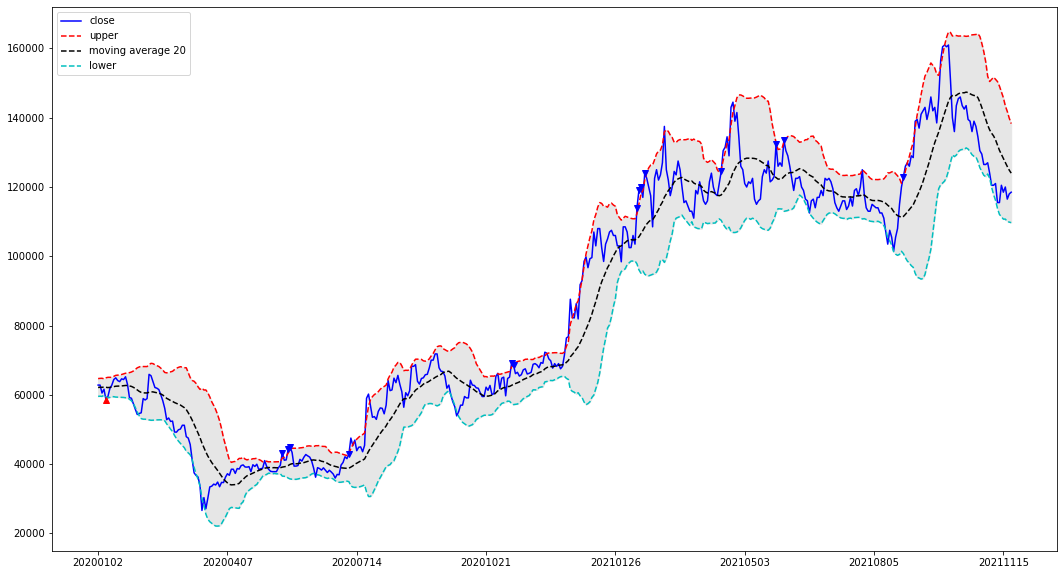

In [21]:
plt.figure(figsize=(18,10))
plt.plot(oci_cut.index, oci_cut['close'], color='#0000ff', label='close')
plt.plot(oci_cut.index, oci_cut['upper'], 'r--', label='upper')
plt.plot(oci_cut.index, oci_cut['MA20'], 'k--', label='moving average 20')
plt.plot(oci_cut.index, oci_cut['lower'], 'c--', label='lower')
plt.fill_between(oci_cut.index, oci_cut['upper'], oci_cut['lower'], color='0.9')
for i in range(len(oci_cut.close)):
    if oci_cut.PB.values[i] <0.05 and oci_cut.IIP21.values[i] > 0:
        plt.plot(oci_cut.index.values[i], oci_cut.close.values[i], 'r^')
    elif oci_cut.PB.values[i] >0.95 and oci_cut.IIP21.values[i] < 0:
        plt.plot(oci_cut.index.values[i], oci_cut.close.values[i], 'bv')
plt.xticks([oci_cut.index[i] for i in range(0,len(oci_cut.index),len(oci_cut.index)//7)])
plt.legend()


In [22]:
balance = pd.DataFrame(columns = ['cash','stock','total'], index = oci.index)

buying = False

buy_date = []
sell_date = []

balance.loc[balance.index[0], 'cash'] = 500000
balance.loc[balance.index[0], 'stock'] = 0
balance.loc[balance.index[0], 'total'] = 500000


for i in range(1, len(oci.close)):
    if buying == False:
        if oci.PB.values[i-1] < 0.05 and oci.IIP21.values[i-1] > 0:
            buying = True
            number = balance.loc[balance.index[i-1], 'cash'] // oci.loc[oci.index[i], 'open']
            balance.loc[balance.index[i], 'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
        else:
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
    else:
        if oci.PB.values[i-1] > 0.95 and oci.IIP21.values[i-1] < 0:
            buying = False
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
        else:
            balance.loc[balance.index[i],'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

    balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']


balance['rate_of_return'] = balance['total'] / 500000

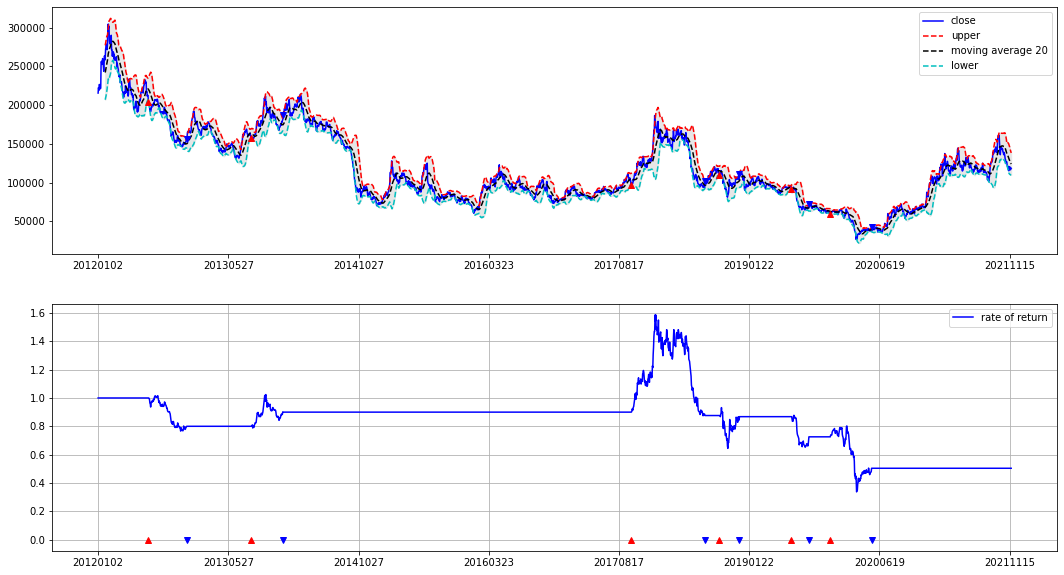

In [23]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['upper'], 'r--', label='upper')
plt.plot(oci.index, oci['MA20'], 'k--', label='moving average 20')
plt.plot(oci.index, oci['lower'], 'c--', label='lower')
plt.fill_between(oci.index, oci['upper'], oci['lower'], color='0.9')
buying = False
for i in range(len(oci.close)):
    if oci.PB.values[i] < 0.05 and oci.IIP21.values[i] > 0 and buying == False:
        buying = True
        plt.plot(oci.index.values[i], oci.close.values[i], 'r^')
    elif oci.PB.values[i] > 0.95 and oci.IIP21.values[i] < 0 and buying == True:
        buying = False
        plt.plot(oci.index.values[i], oci.close.values[i], 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(oci.index, balance['rate_of_return'], color='b', label='rate of return')
buying = False
for i in range(len(oci.close)):
    if oci.PB.values[i] < 0.05 and oci.IIP21.values[i] > 0 and buying == False:
        buying = True
        plt.plot(oci.index.values[i], 0, 'r^')
    elif oci.PB.values[i] > 0.95 and oci.IIP21.values[i] < 0 and buying == True:
        buying = False
        plt.plot(oci.index.values[i], 0, 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.grid(True)
plt.show()


In [24]:
oci.IIP21

20120102          NaN
20120103          NaN
20120104          NaN
20120105          NaN
20120106          NaN
              ...    
20211115   -42.197879
20211116   -42.179317
20211117   -41.854392
20211118   -39.081374
20211119   -34.340585
Name: IIP21, Length: 2434, dtype: float64

# 삼중창 매매 시스템

# 첫번째창

In [25]:
oci['ema60'] = oci['close'].ewm(span=60).mean()
oci['ema130'] = oci['close'].ewm(span=130).mean()
oci['macd'] = oci['ema60'] - oci['ema130']
oci['signal'] = oci['macd'].ewm(span=45).mean()
oci['macdhist'] = oci['macd'] - oci['signal']

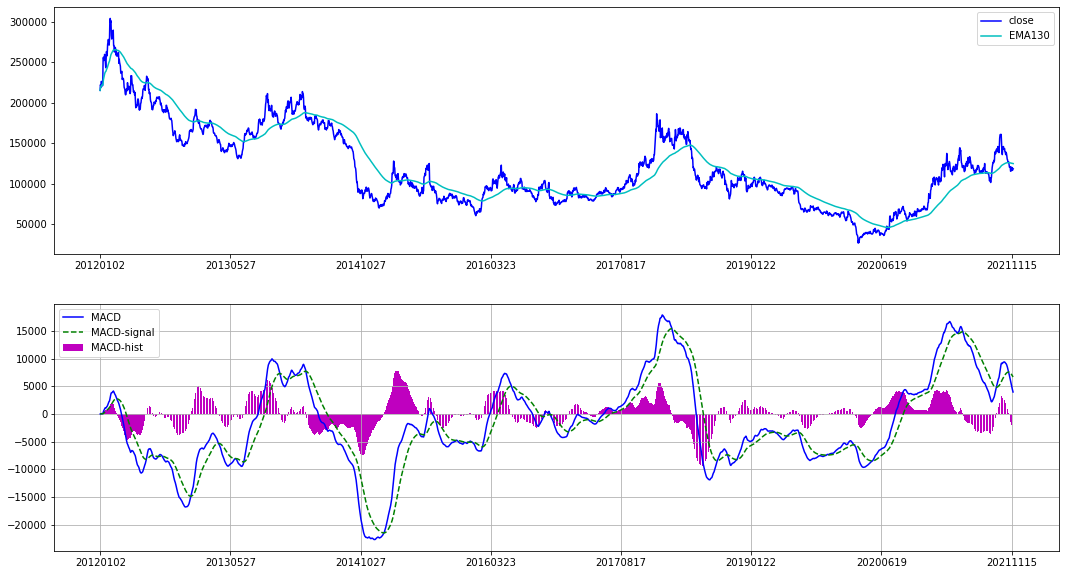

In [26]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['ema130'], color='c', label='EMA130')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.grid(True)
plt.bar(oci.index, oci['macdhist'], color='m', label='MACD-hist')
plt.plot(oci.index, oci['macd'], color='b', label='MACD')
plt.plot(oci.index, oci['signal'], 'g--', label='MACD-signal')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.show()

In [27]:
balance = pd.DataFrame(columns = ['cash','stock','total'], index = oci.index)

buying = False

buy_date = []
sell_date = []

balance.loc[balance.index[0], 'cash'] = 500000
balance.loc[balance.index[0], 'stock'] = 0
balance.loc[balance.index[0], 'total'] = 500000


balance.loc[balance.index[1], 'cash'] = 500000
balance.loc[balance.index[1], 'stock'] = 0
balance.loc[balance.index[1], 'total'] = 500000


for i in range(2, len(oci.close)):
    if buying == False:
        if oci.ema130.values[i-2] < oci.ema130.values[i-1]:
            buying = True
            number = balance.loc[balance.index[i-1], 'cash'] // oci.loc[oci.index[i], 'open']
            balance.loc[balance.index[i], 'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
        else:
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
    else:
        if oci.ema130.values[i-2] > oci.ema130.values[i-1]:
            buying = False
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
        else:
            balance.loc[balance.index[i],'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

    balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']


balance['rate_of_return'] = balance['total'] / 500000

In [28]:
balance

,cash,stock,total,rate_of_return
20120102,500000,0,500000,1.0
20120103,500000,0,500000,1.0
20120104,53000,447000,500000,1.0
20120105,500000,0,500000,1.0
20120106,49000,451000,500000,1.0
...,...,...,...,...
20211115,2742600,0,2742600,5.4852
20211116,2742600,0,2742600,5.4852
20211117,2742600,0,2742600,5.4852
20211118,2742600,0,2742600,5.4852


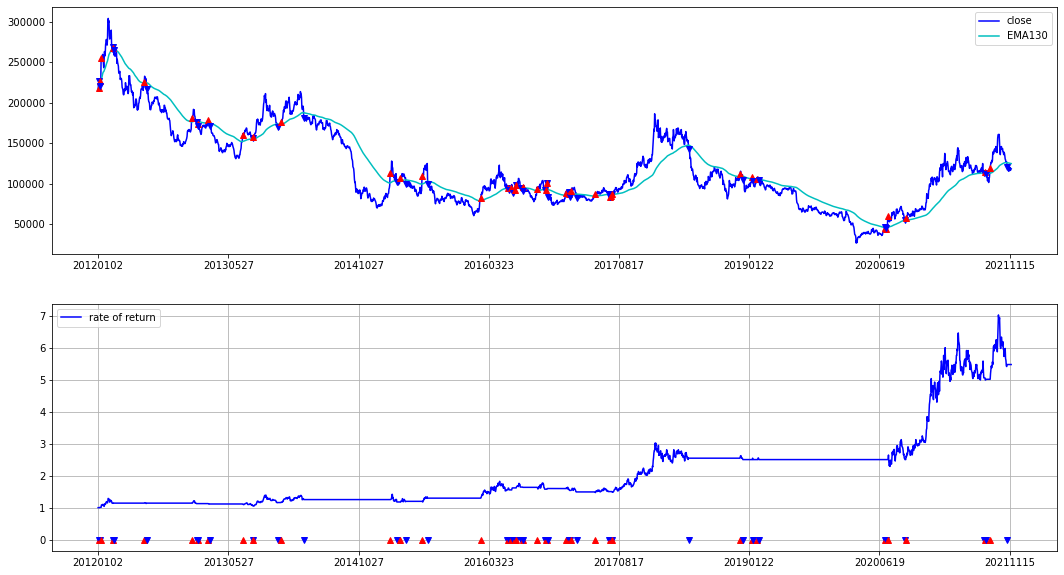

In [29]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['ema130'], color='c', label='EMA130')
buying = False
for i in range(2,len(oci.close)):
    if oci.ema130.values[i-2] < oci.ema130.values[i-1] and buying == False:
        buying = True
        plt.plot(oci.index.values[i], oci.close.values[i], 'r^')
    elif oci.ema130.values[i-2] > oci.ema130.values[i-1] and buying == True:
        buying = False
        plt.plot(oci.index.values[i], oci.close.values[i], 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.plot(oci.index, balance['rate_of_return'], color='b', label='rate of return')
buying = False
for i in range(2,len(oci.close)-2):
    if oci.ema130.values[i-2] < oci.ema130.values[i-1] and buying == False:
        buying = True
        plt.plot(oci.index.values[i], 0, 'r^')
    elif oci.ema130.values[i-2] > oci.ema130.values[i-1] and buying == True:
        buying = False
        plt.plot(oci.index.values[i], 0, 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.grid(True)
plt.show()

# 두번째창

In [30]:
ndays_high = oci['high'].rolling(window=14, min_periods=1).max()
ndays_low = oci['low'].rolling(window=14, min_periods=1).min()
oci['fast_k'] = (oci.close - ndays_low) / (ndays_high - ndays_low) * 100
oci['slow_d'] = oci['fast_k'].rolling(window=3).mean()

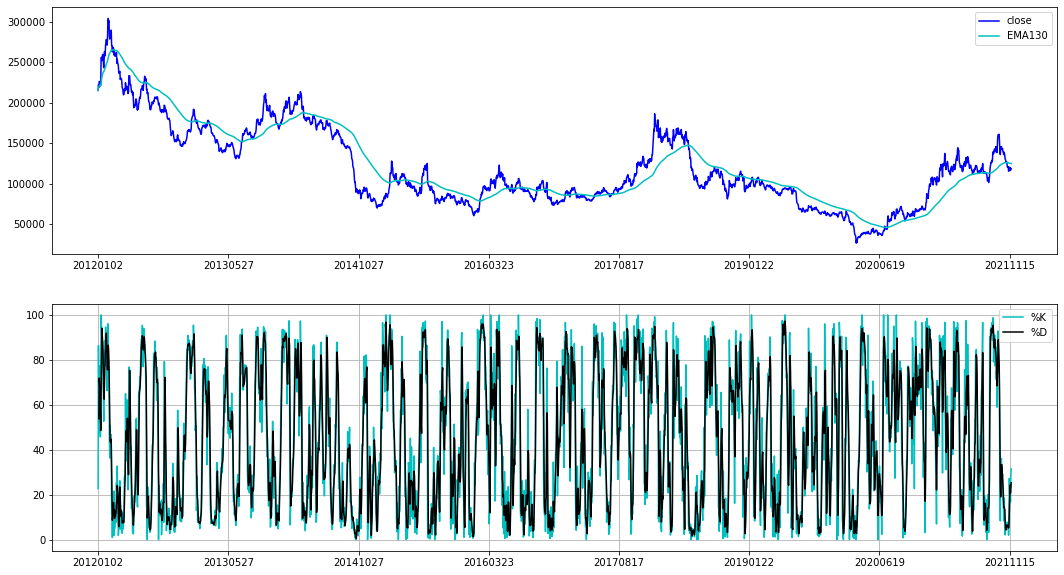

In [31]:
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['ema130'], color='c', label='EMA130')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(2,1,2)
plt.grid(True)
plt.plot(oci.index, oci['fast_k'], color='c', label='%K')
plt.plot(oci.index, oci['slow_d'], color='k', label='%D')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.show()

In [32]:
def buy_signal(i):
    return oci.ema130.values[i-2] < oci.ema130.values[i-1] and oci.slow_d.values[i-1] < 20

def sell_signal(i):
    return oci.ema130.values[i-2] > oci.ema130.values[i-1] and oci.slow_d.values[i-1] > 80
    

In [33]:
balance = pd.DataFrame(columns = ['cash','stock','total'], index = oci.index)

buying = False

buy_date = []
sell_date = []

balance.loc[balance.index[0], 'cash'] = 500000
balance.loc[balance.index[0], 'stock'] = 0
balance.loc[balance.index[0], 'total'] = 500000

balance.loc[balance.index[1], 'cash'] = 500000
balance.loc[balance.index[1], 'stock'] = 0
balance.loc[balance.index[1], 'total'] = 500000

sell_price = 0
for i in range(2, len(oci.open)):
    if buying == False:
        if buy_signal(i):
            buying = True
            number = balance.loc[balance.index[i-1], 'cash'] // oci.loc[oci.index[i], 'open']
            balance.loc[balance.index[i], 'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
        else:
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
    else:
        if sell_signal(i):
            buying = False
            sell_price=0
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
        else:
            balance.loc[balance.index[i],'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

    balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']


balance['rate_of_return'] = balance['total'] / 500000

<AxesSubplot:>

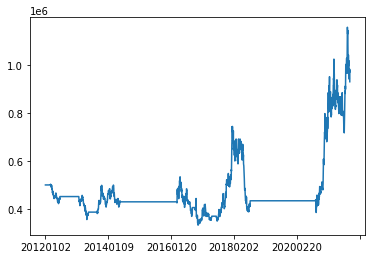

In [34]:
balance.loc[:'202111'].total.plot()

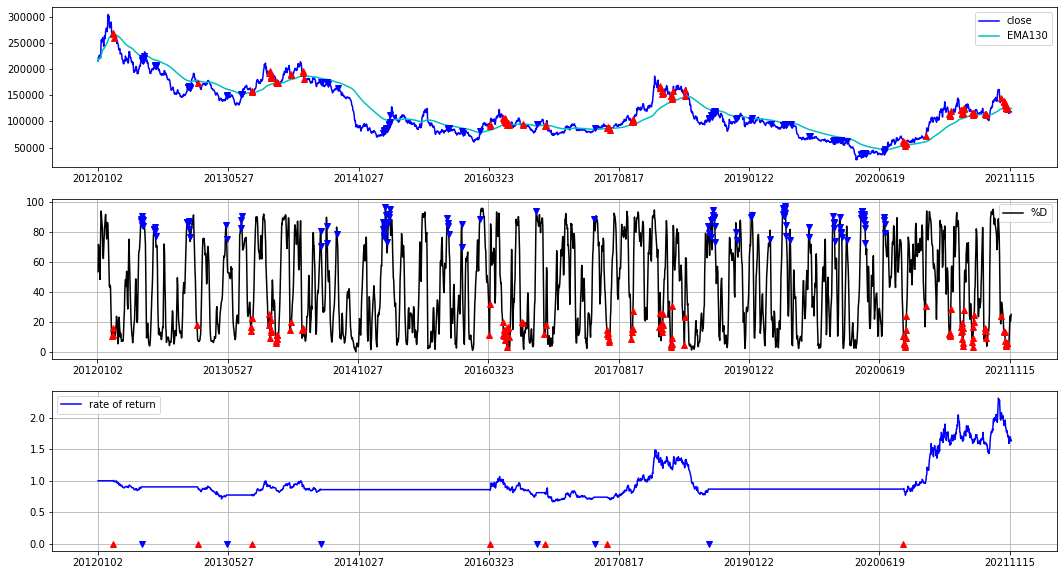

In [35]:
plt.figure(figsize=(18,10))
plt.subplot(3,1,1)
plt.plot(oci.index, oci['close'], color='#0000ff', label='close')
plt.plot(oci.index, oci['ema130'], color='c', label='EMA130')
buying = False
for i in range(1,len(oci.close)):
    if buy_signal(i):
        buying = True
        plt.plot(oci.index.values[i], oci.close.values[i], 'r^')
    elif sell_signal(i):
        buying = False
        plt.plot(oci.index.values[i], oci.close.values[i], 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()


plt.subplot(3,1,2)
plt.grid(True)
plt.plot(oci.index, oci['slow_d'], color='k', label='%D')
buying = False
for i in range(1,len(oci.close)-2):
    if buy_signal(i):
        buying = True
        plt.plot(oci.index.values[i], oci.slow_d.values[i], 'r^')
    elif sell_signal(i):
        buying = False
        plt.plot(oci.index.values[i], oci.slow_d.values[i], 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()

plt.subplot(3,1,3)
plt.plot(oci.index, balance['rate_of_return'], color='b', label='rate of return')
buying = False
for i in range(1,len(oci.close)-2):
    if buy_signal(i) and buying == False:
        buying = True
        plt.plot(oci.index.values[i], 0, 'r^')
    elif sell_signal(i) and buying == True:
        buying = False
        plt.plot(oci.index.values[i], 0, 'bv')
plt.xticks([oci.index[i] for i in range(0,len(oci.index),len(oci.index)//7)])
plt.legend()
plt.grid(True)
plt.show()

In [36]:
balance = pd.DataFrame(columns = ['cash','stock','total'], index = oci.index)

buying = False

buy_date = []
sell_date = []

balance.loc[balance.index[0], 'cash'] = 500000
balance.loc[balance.index[0], 'stock'] = 0
balance.loc[balance.index[0], 'total'] = 500000

balance.loc[balance.index[1], 'cash'] = 500000
balance.loc[balance.index[1], 'stock'] = 0
balance.loc[balance.index[1], 'total'] = 500000

balance.loc[balance.index[2], 'cash'] = 500000
balance.loc[balance.index[2], 'stock'] = 0
balance.loc[balance.index[2], 'total'] = 500000

j=0

for i in range(3, len(oci.close)):
    if buying == False:
        if oci.ema130.values[i-3] < oci.ema130.values[i-2] < oci.ema130.values[i-1]:
            buying = True
            j += 1
            number = balance.loc[balance.index[i-1], 'cash'] // oci.loc[oci.index[i], 'open']
            balance.loc[balance.index[i], 'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
        else:
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
    else:
        if oci.ema130.values[i-3] < oci.ema130.values[i-2] < oci.ema130.values[i-1]:
            buying = False
            j += 1
            balance.loc[balance.index[i], 'stock'] = 0
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
        else:
            balance.loc[balance.index[i],'stock'] = oci.loc[oci.index[i], 'open'] * number
            balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

    balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']


balance['rate_of_return'] = balance['total'] / 500000

In [37]:
balance

,cash,stock,total,rate_of_return
20120102,500000,0,500000,1.0
20120103,500000,0,500000,1.0
20120104,500000,0,500000,1.0
20120105,500000,0,500000,1.0
20120106,500000,0,500000,1.0
...,...,...,...,...
20211115,212400,0,212400,0.4248
20211116,212400,0,212400,0.4248
20211117,212400,0,212400,0.4248
20211118,212400,0,212400,0.4248


In [38]:
j

942

In [39]:
def ema130(price_df):
    price_df['ema130'] = price_df['close'].ewm(span=130).mean()

    balance = pd.DataFrame(columns = ['cash','stock','total'], index = price_df.index)
    buying = False
    balance.loc[balance.index[0], 'cash'] = 500000
    balance.loc[balance.index[0], 'stock'] = 0
    balance.loc[balance.index[0], 'total'] = 500000
    balance.loc[balance.index[1], 'cash'] = 500000
    balance.loc[balance.index[1], 'stock'] = 0
    balance.loc[balance.index[1], 'total'] = 500000
    for i in range(2, len(price_df.close)):
        if buying == False:
            if price_df.ema130.values[i-2] < price_df.ema130.values[i-1] and price_df.loc[price_df.index[i],'open'] != 0:
                buying = True
                number = balance.loc[balance.index[i-1], 'cash'] // price_df.loc[price_df.index[i], 'open']
                balance.loc[balance.index[i], 'stock'] = price_df.loc[price_df.index[i], 'open'] * number
                balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash'] - balance.loc[balance.index[i], 'stock']
            else:
                balance.loc[balance.index[i], 'stock'] = 0
                balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']
        else:
            if price_df.ema130.values[i-2] > price_df.ema130.values[i-1]:
                buying = False
                balance.loc[balance.index[i], 'stock'] = 0
                balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'stock'] + balance.loc[balance.index[i-1], 'cash']
            else:
                balance.loc[balance.index[i],'stock'] = price_df.loc[price_df.index[i], 'open'] * number
                balance.loc[balance.index[i], 'cash'] = balance.loc[balance.index[i-1], 'cash']

        balance.loc[balance.index[i], 'total'] = balance.loc[balance.index[i], 'stock'] + balance.loc[balance.index[i], 'cash']


    balance['rate_of_return'] = balance['total'] / 500000

    return balance

In [40]:
samsung = ema130(stock_price['A005930'].copy())

In [41]:
samsung.rate_of_return[-1]

4.211644

In [42]:
korea_corporation = pd.read_csv('korea_corporation.csv')
korea_corporation = korea_corporation[korea_corporation['주식종류'] == '보통주']
kospi = korea_corporation[korea_corporation['시장구분'] == 'KOSPI'][['단축코드','한글 종목약명']].reset_index(drop=True)
kosdaq = korea_corporation[korea_corporation['시장구분'] == 'KOSDAQ'][['단축코드','한글 종목약명']].reset_index(drop=True)
kospi_200 = pd.read_csv('kospi_200.csv', index_col = 0)
korea_corporation = korea_corporation[['단축코드', '한글 종목약명']]

FileNotFoundError: [Errno 2] No such file or directory: 'korea_corporation.csv'

In [ ]:
rate_of_return = {}
rate_of_return['name'] = []
rate_of_return['ema130'] = []
rate_of_return['stock'] = []

for i in korea_corporation.index:
    code = korea_corporation.loc[i, '단축코드']
    name = korea_corporation.loc[i, '한글 종목약명']
    balance = ema130(stock_price[code].copy())
    rate_of_return['name'].append(name)
    rate_of_return['ema130'].append(balance.rate_of_return[-1])
    rate_of_return['stock'].append(stock_price[code]['open'][-1] / stock_price[code]['open'][0])

<ipython-input-230-687339e37fc9>:12: RuntimeWarning: divide by zero encountered in long_scalars
  rate_of_return['stock'].append(stock_price[code]['market_price'][-1] / stock_price[code]['market_price'][0])
<ipython-input-230-687339e37fc9>:12: RuntimeWarning: invalid value encountered in long_scalars
  rate_of_return['stock'].append(stock_price[code]['market_price'][-1] / stock_price[code]['market_price'][0])


In [ ]:
test1 = pd.DataFrame(rate_of_return)

In [ ]:
test1

,name,ema130,stock
0,마이크로컨텍솔,15.529690,3.144654
1,스카이이앤엠,1.411816,0.022461
2,포스코엠텍,9.219494,1.048518
3,AJ네트웍스,2.331022,NaN
4,AK홀딩스,6.448366,0.943285
...,...,...,...
2467,흥국에프엔비,2.746618,NaN
2468,흥국화재,2.891620,0.647414
2469,흥아해운,3.500596,0.393649
2470,희림,2.180630,1.276527


In [ ]:
korea_corporation = korea_corporation.reset_index(drop=True)
korea_corporation

,단축코드,한글 종목약명
0,A098120,마이크로컨텍솔
1,A131100,스카이이앤엠
2,A009520,포스코엠텍
3,A095570,AJ네트웍스
4,A006840,AK홀딩스
...,...,...
2467,A189980,흥국에프엔비
2468,A000540,흥국화재
2469,A003280,흥아해운
2470,A037440,희림


In [ ]:
null_data = test1.stock.isnull()

for i in test1.index:
    if null_data[i] == True:
        test1.loc[i,'stock'] = stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['open'][-1] / stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['open'][0]
        
        

<ipython-input-253-7e117d252040>:5: RuntimeWarning: divide by zero encountered in double_scalars
  test1.loc[i,'stock'] = stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][-1] / stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][0]
<ipython-input-253-7e117d252040>:5: RuntimeWarning: invalid value encountered in long_scalars
  test1.loc[i,'stock'] = stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][-1] / stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][0]
<ipython-input-253-7e117d252040>:5: RuntimeWarning: divide by zero encountered in double_scalars
  test1.loc[i,'stock'] = stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][-1] / stock_price[korea_corporation.loc[i, '단축코드']].dropna(axis=0)['market_price'][0]
<ipython-input-253-7e117d252040>:5: RuntimeWarning: divide by zero encountered in double_scalars
  test1.loc[i,'stock'] = stock_price[korea_corporat